In [1]:
#this script allows you to convert any earth map from python to civmap
#you can modify latitude,longitude and projection to get any earth map
#in the demonstration below I use basemap package
#technically u can use any map even non-map 
#u just have to map different pixel colors to terrains
#it also automatically generates natural wonders
#geotags features, resources,
#continents and true start locations
#based upon coordinates provided in the spreadsheets
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import sklearn.mixture
import sklearn.cluster
os.chdir('K:/ecole/github/televerser/civ6')

### read civmap

In [2]:
#create copy then rename
#i strongly encourage you to create a blank map then load it into python
#the directory of customized map from world builder
# C:\Users\your_user_name\Documents\My Games\Sid Meier's Civilization VI\Saves\WorldBuilder
os.system('copy nouveau.Civ6Map copie.Civ6Map')

#essentially civ6map is a sql database
os.rename('nouveau.Civ6Map','civ.db')

### global variables

In [3]:
#define no resource land
#the sparsity affects how dbscan creates clusters
#each cluster centre will be placed with ley line
tolerance4noresource=3

#scaler determines the cutoff latitude
scaler=62000

#determine the map centre
lon_centre=40
lat_centre=25

#one of the projection types
projection_type='aeqd'

#determine map orientation
horizontal=True

# #viking
# scaler=32000
# lon_centre=-2
# lat_centre=65

# #arctic circle
# scaler=140000
# lon_centre=-70
# lat_centre=80

# #king arthur
# scaler=14000
# lon_centre=-4
# lat_centre=55

# #italia
# scaler=16000
# lon_centre=13
# lat_centre=42

# #greco
# scaler=14500
# lon_centre=24.5
# lat_centre=40

# #baltique
# scaler=23000
# lon_centre=18
# lat_centre=61

# #iberia
# scaler=19000
# lon_centre=-3
# lat_centre=40

# #america du sud
# scaler=83000
# lon_centre=-58
# lat_centre=-22

# #america du nord
# scaler=120000
# lon_centre=-110
# lat_centre=43

# #afrique
# scaler=120000
# lon_centre=15
# lat_centre=0

# #mer rouge
# scaler=35000
# lon_centre=40
# lat_centre=20

# #asean
# scaler=42000
# lon_centre=105
# lat_centre=5


# #horizontal map

# #ukraine
# scaler=27000
# lon_centre=35
# lat_centre=49.5

# #mideast
# scaler=62000
# lon_centre=40
# lat_centre=25

# #carribean
# scaler=39000
# lon_centre=-78
# lat_centre=19

# #asean
# scaler=80000
# lon_centre=130
# lat_centre=-1

# #sahara
# scaler=60000
# lon_centre=12
# lat_centre=20

# #antartica
# scaler=240000
# lon_centre=60
# lat_centre=-90

#indo subcontinent
# scaler=62000
# lon_centre=75
# lat_centre=22

#oceania
# scaler=80000
# lon_centre=135
# lat_centre=-28

In [4]:
#map terrain into different colors for viz
terrain2color={'TERRAIN_COAST': '#16396c',
 'TERRAIN_DESERT': '#b18e35',
 'TERRAIN_DESERT_HILLS': '#b18e35',
 'TERRAIN_DESERT_MOUNTAIN': '#b18e35',
 'TERRAIN_GRASS': '#2b3317',
 'TERRAIN_GRASS_HILLS': '#2b3317',
 'TERRAIN_GRASS_MOUNTAIN': '#2b3317',
 'TERRAIN_OCEAN': '#050e24',
 'TERRAIN_PLAINS': '#90aa6e',
 'TERRAIN_PLAINS_HILLS': '#90aa6e',
 'TERRAIN_PLAINS_MOUNTAIN': '#90aa6e',
 'TERRAIN_SNOW': '#eceeee',
 'TERRAIN_SNOW_HILLS': '#eceeee',
 'TERRAIN_SNOW_MOUNTAIN': '#eceeee',
 'TERRAIN_TUNDRA': '#a09b90',
 'TERRAIN_TUNDRA_HILLS': '#a09b90',
 'TERRAIN_TUNDRA_MOUNTAIN': '#a09b90'}

#map colors into different terrains
#remove mountain tiles for simplicity
color2terrain={
 '#90aa6e': 'TERRAIN_PLAINS',
 '#16396c': 'TERRAIN_COAST',
 '#b18e35': 'TERRAIN_DESERT',
 '#2b3317': 'TERRAIN_GRASS',
 '#eceeee': 'TERRAIN_SNOW',
 '#a09b90': 'TERRAIN_TUNDRA',
 '#050e24': 'TERRAIN_OCEAN',}

#land and sea mask for sanity check
masque={
'#000000': 'TERRAIN_PLAINS',
'#FFFFFF': 'TERRAIN_COAST',}

#get elevation data from etopo
topo_color={'#705d18': '_MOUNTAIN',
 '#deae42': '_HILLS',
 '#eed0ae': '',
 '#337518': '',
 '#7fce7a': '',
 '#a8d5f2': '',
 '#063bab': '',
 '#8c6061': '',
 '#e2e2e2': ''}

#leverage continent to differentiate tundra from desert
tundra_desert_dif={'CONTINENT_AUSTRALIA':['TUNDRA','DESERT'],
'CONTINENT_AFRICA':['TUNDRA','DESERT'],
'CONTINENT_ATLANTIS':['TUNDRA','DESERT'],
'CONTINENT_AZANIA':['TUNDRA','DESERT'],
'CONTINENT_CIMMERIA':['DESERT','TUNDRA',],
'CONTINENT_BALTICA':['DESERT','TUNDRA',],
'CONTINENT_SIBERIA':['DESERT','TUNDRA',],
'CONTINENT_ARCTICA':['DESERT','TUNDRA',],
 'CONTINENT_ANTARCTICA':['DESERT','TUNDRA',],
'CONTINENT_ZEALANDIA':['DESERT','TUNDRA',],}

In [5]:
#useful for players table construction
human_player={'ID': {0: 0},
 'CivilizationType': {0: 'UNDEFINED'},
 'LeaderType': {0: 'UNDEFINED'},
 'CivilizationLevelType': {0: 'CIVILIZATION_LEVEL_FULL_CIV'},
 'AgendaType': {0: ''},
 'Status': {0: 'Human'},
 'Handicap': {0: None},
 'StartingPosition': {0: None},
 'Color': {0: None},
 'Initialized': {0: 0}}

ai_civs={'ID': {1: 1},
 'CivilizationType': {1: 'UNDEFINED'},
 'LeaderType': {1: 'UNDEFINED'},
 'CivilizationLevelType': {1: 'CIVILIZATION_LEVEL_FULL_CIV'},
 'AgendaType': {1: ''},
 'Status': {1: 'AI'},
 'Handicap': {1: None},
 'StartingPosition': {1: None},
 'Color': {1: None},
 'Initialized': {1: 0}}

ai_cities={'ID': {23: 25},
 'CivilizationType': {23: 'RANDOM'},
 'LeaderType': {23: 'RANDOM'},
 'CivilizationLevelType': {23: 'CIVILIZATION_LEVEL_CITY_STATE'},
 'AgendaType': {23: ''},
 'Status': {23: 'AI'},
 'Handicap': {23: None},
 'StartingPosition': {23: None},
 'Color': {23: None},
 'Initialized': {23: 1}}

In [6]:
#impassable terrains
impassable_terrains=['TERRAIN_DESERT_MOUNTAIN',
 'TERRAIN_GRASS_MOUNTAIN',
 'TERRAIN_PLAINS_MOUNTAIN',
 'TERRAIN_SNOW_MOUNTAIN',
 'TERRAIN_TUNDRA_MOUNTAIN']

In [7]:
#the boundary of each continent in polygon shape
continent_area={'CONTINENT_ARCTICA':
                {'lat': [65, 90, 90, 65],
                       'lon': [-180, -180, 180, 180]},
 'CONTINENT_ANTARCTICA': {'lat': [-90, -60, -60, -90],
  'lon': [-180, -180, 180, 180]},
 'CONTINENT_SOUTH_AMERICA': {'lat': [-60, 10, 10, -60],
  'lon': [-180, -180, -30, -30]},
 'CONTINENT_AMERICA': {'lat': [30, 10, 10, 30],
  'lon': [-180, -180, -30, -30]},
 'CONTINENT_NORTH_AMERICA': {'lat': [30, 65, 65, 30],
  'lon': [-180, -180, -30, -30]},
 'CONTINENT_ZEALANDIA': {'lat': [-60, -30, -30, -60],
  'lon': [160, 160, 180, 180]},
 'CONTINENT_VAALBARA': {'lat': [-60, -10, -10, -60],
                        'lon': [40, 40, 120, 120]},
 'CONTINENT_AUSTRALIA': {'lat': [-60, -10, -10, -60],
  'lon': [120, 120, 160, 160]},
 'CONTINENT_CONGO_CRATON': {'lat': [-10, 0, 0, -10],
                            'lon': [-30, -30, 60, 60]},
 'CONTINENT_KALAHARIA': {'lat': [-60, -10, -10, -60],
                         'lon': [-30, -30, 40, 40]},
 'CONTINENT_AFRICA': {'lat': [0, 20, 20, 0],
                      'lon': [-30, -30, 25, 25]},
 'CONTINENT_ATLANTIS': {'lat': [20, 35, 35, 20],
                        'lon': [-30, -30, 25, 25]},
 'CONTINENT_AZANIA': {'lat': [0, 35, 35, 0],
                      'lon': [25, 25, 60, 60]},
 'CONTINENT_CIMMERIA': {'lat': [-10, 35, 35, -10],
                        'lon': [60, 60, 90, 90]},
 'CONTINENT_KAZAKHSTANIA': {'lat': [35, 55, 55, 35],
                            'lon': [30, 30, 90, 90]},
 'CONTINENT_ASIA': {'lat': [-10, 55, 55, -10],
                    'lon': [90, 90, 180, 180]},
 'CONTINENT_OCEANIA': {'lat': [-30, 20, 20, -30],
                       'lon': [150,150,180,180]},
 'CONTINENT_EUROPE': {'lat': [35, 65, 65, 35],
                      'lon': [-30, -30, 30, 30]},
 'CONTINENT_BALTICA': {'lat': [55, 65, 65, 55],
                       'lon': [0, 0, 30, 30]},
 'CONTINENT_SIBERIA': {'lat': [55, 65, 65, 55],
                       'lon':[30,30,180,180]},}

In [8]:
#specify the required terrains and probs for features
#this can be found from
#{game dir}/Base/Assets/Gameplay/Data/Features.xml
#and also numerous dlc directories...
feature_mapping={
    'FEATURE_MARSH':{'terrains':['TERRAIN_GRASS',
                                 'TERRAIN_PLAINS','TERRAIN_DESERT'],
                'prob':0.05},     
    'FEATURE_REEF':{'terrains':
                                 ['TERRAIN_COAST'],
                'prob':1},
'FEATURE_VOLCANO':{'terrains':impassable_terrains,
                'prob':0.02},
'FEATURE_JUNGLE':{'terrains':['TERRAIN_GRASS',
 'TERRAIN_GRASS_HILLS',
 'TERRAIN_PLAINS',
 'TERRAIN_PLAINS_HILLS',],
                'prob':1},
'FEATURE_FOREST':{'terrains':['TERRAIN_GRASS',
 'TERRAIN_PLAINS',
 'TERRAIN_TUNDRA',
 'TERRAIN_GRASS_HILLS',
 'TERRAIN_PLAINS_HILLS',
 'TERRAIN_TUNDRA_HILLS'],
                'prob':1},
'FEATURE_OASIS':{'terrains':['TERRAIN_DESERT'],
                'prob':0.05},
'FEATURE_GEOTHERMAL_FISSURE':{'terrains':
                              ['TERRAIN_DESERT',
    'TERRAIN_DESERT_HILLS','TERRAIN_GRASS',
  'TERRAIN_GRASS_HILLS','TERRAIN_PLAINS',
 'TERRAIN_PLAINS_HILLS', 'TERRAIN_SNOW',
 'TERRAIN_SNOW_HILLS', 'TERRAIN_TUNDRA',
'TERRAIN_TUNDRA_HILLS',],
                'prob':0.2},
 'FEATURE_VOLCANIC_SOIL':{'terrains':
                          ['TERRAIN_DESERT',
    'TERRAIN_DESERT_HILLS','TERRAIN_GRASS',
  'TERRAIN_GRASS_HILLS','TERRAIN_PLAINS',
 'TERRAIN_PLAINS_HILLS', 'TERRAIN_SNOW',
 'TERRAIN_SNOW_HILLS','TERRAIN_TUNDRA',
'TERRAIN_TUNDRA_HILLS',],
                'prob':0.4},} 

In [9]:
#specify the required terrains and features for resources
#and its frequency across the continents
#this can be found from
#{game dir}/Base/Assets/Gameplay/Data/Resources.xml
#and also numerous dlc directories...
resource_mapping={'RESOURCE_MARBLE': {'features': np.nan,
  'terrains': 'TERRAIN_GRASS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS',
  'prob': 0.005},
 'RESOURCE_NITER': {'features': 'FEATURE_FLOODPLAINS_GRASSLAND;FEATURE_FLOODPLAINS_PLAINS',
  'terrains': 'TERRAIN_GRASS;TERRAIN_DESERT;TERRAIN_PLAINS;TERRAIN_TUNDRA',
  'prob': 0.005},
 'RESOURCE_JADE': {'features': np.nan,
  'terrains': 'TERRAIN_PLAINS;TERRAIN_TUNDRA;TERRAIN_GRASS',
  'prob': 0.005},
 'RESOURCE_AMBER': {'features': 'FEATURE_JUNGLE;FEATURE_FOREST',
  'terrains': 'TERRAIN_COAST',
  'prob': 0.005},
 'RESOURCE_TRUFFLES': {'features': 'FEATURE_MARSH;FEATURE_FOREST;FEATURE_JUNGLE',
  'terrains': np.nan,
  'prob': 0.005},
 'RESOURCE_TOBACCO': {'features': 'FEATURE_FOREST;FEATURE_JUNGLE',
  'terrains': 'TERRAIN_GRASS;TERRAIN_PLAINS',
  'prob': 0.005},
 'RESOURCE_BANANAS': {'features': 'FEATURE_JUNGLE',
  'terrains': np.nan,
  'prob': 0.005},
 'RESOURCE_MERCURY': {'features': np.nan,
  'terrains': 'TERRAIN_PLAINS',
  'prob': 0.01},
 'RESOURCE_RICE': {'features': 'FEATURE_FLOODPLAINS_GRASSLAND;FEATURE_MARSH',
  'terrains': 'TERRAIN_GRASS',
  'prob': 0.005},
 'RESOURCE_ALUMINUM': {'features': 'FEATURE_JUNGLE',
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_DESERT;TERRAIN_PLAINS;TERRAIN_SNOW_HILLS;TERRAIN_SNOW',
  'prob': 0.05},
 'RESOURCE_INCENSE': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT;TERRAIN_PLAINS',
  'prob': 0.005},
 'RESOURCE_HONEY': {'features': np.nan,
  'terrains': 'TERRAIN_GRASS;TERRAIN_PLAINS',
  'prob': 0.005},
 'RESOURCE_COFFEE': {'features': 'FEATURE_JUNGLE',
  'terrains': 'TERRAIN_GRASS',
  'prob': 0.005},
 'RESOURCE_WHEAT': {'features': 'FEATURE_FLOODPLAINS;FEATURE_FLOODPLAINS_PLAINS',
  'terrains': 'TERRAIN_PLAINS',
  'prob': 0.005},
 'RESOURCE_SPICES': {'features': 'FEATURE_FOREST;FEATURE_JUNGLE',
  'terrains': np.nan,
  'prob': 0.005},
 'RESOURCE_DIAMONDS': {'features': 'FEATURE_JUNGLE',
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_TUNDRA_HILLS;TERRAIN_SNOW_HILLS;TERRAIN_SNOW',
  'prob': 0.01},
 'RESOURCE_CITRUS': {'features': np.nan,
  'terrains': 'TERRAIN_GRASS;TERRAIN_PLAINS',
  'prob': 0.005},
 'RESOURCE_MAIZE': {'features': 'FEATURE_FLOODPLAINS_GRASSLAND;FEATURE_FLOODPLAINS_PLAINS',
  'terrains': 'TERRAIN_GRASS;TERRAIN_PLAINS',
  'prob': 0.005},
 'RESOURCE_COTTON': {'features': 'FEATURE_FLOODPLAINS;FEATURE_FLOODPLAINS_GRASSLAND;FEATURE_FLOODPLAINS_PLAINS',
  'terrains': 'TERRAIN_GRASS;TERRAIN_PLAINS',
  'prob': 0.005},
 'RESOURCE_SILK': {'features': 'FEATURE_FOREST',
  'terrains': np.nan,
  'prob': 0.005},
 'RESOURCE_URANIUM': {'features': 'FEATURE_JUNGLE;FEATURE_FOREST',
  'terrains': 'TERRAIN_DESERT;TERRAIN_DESERT_HILLS;TERRAIN_GRASS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS;TERRAIN_PLAINS_HILLS;TERRAIN_SNOW;TERRAIN_SNOW_HILLS;TERRAIN_TUNDRA;TERRAIN_TUNDRA_HILLS',
  'prob': 0.002},
 'RESOURCE_IVORY': {'features': 'FEATURE_JUNGLE;FEATURE_FOREST',
  'terrains': 'TERRAIN_DESERT;TERRAIN_PLAINS;TERRAIN_PLAINS_HILLS',
  'prob': 0.005},
 'RESOURCE_COAL': {'features': 'FEATURE_FOREST',
  'terrains': 'TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_SNOW_HILLS;TERRAIN_SNOW',
  'prob': 0.008},
 'RESOURCE_SALT': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT;TERRAIN_PLAINS;TERRAIN_TUNDRA',
  'prob': 0.01},
 'RESOURCE_OIL': {'features': 'FEATURE_MARSH;FEATURE_FLOODPLAINS',
  'terrains': 'TERRAIN_COAST;TERRAIN_DESERT;TERRAIN_SNOW;TERRAIN_TUNDRA',
  'prob': 0.01},
 'RESOURCE_TEA': {'features': np.nan,
  'terrains': 'TERRAIN_GRASS;TERRAIN_GRASS_HILLS',
  'prob': 0.005},
 'RESOURCE_IRON': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_TUNDRA_HILLS;TERRAIN_SNOW;TERRAIN_SNOW_HILLS',
  'prob': 0.02},
 'RESOURCE_OLIVES': {'features': np.nan,
  'terrains': 'TERRAIN_GRASS',
  'prob': 0.01},
 'RESOURCE_SUGAR': {'features': 'FEATURE_FLOODPLAINS;FEATURE_MARSH;FEATURE_FLOODPLAINS_GRASSLAND;FEATURE_FLOODPLAINS_PLAINS',
  'terrains': np.nan,
  'prob': 0.005},
 'RESOURCE_WINE': {'features': 'FEATURE_FOREST',
  'terrains': 'TERRAIN_GRASS;TERRAIN_PLAINS',
  'prob': 0.005},
 'RESOURCE_HORSES': {'features': np.nan,
  'terrains': 'TERRAIN_GRASS;TERRAIN_PLAINS',
  'prob': 0.01},
 'RESOURCE_SILVER': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT;TERRAIN_TUNDRA;TERRAIN_DESERT_HILLS;TERRAIN_TUNDRA_HILLS;TERRAIN_SNOW;TERRAIN_SNOW_HILLS',
  'prob': 0.01},
 'RESOURCE_COPPER': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_SNOW_HILLS;TERRAIN_SNOW;TERRAIN_TUNDRA_HILLS',
  'prob': 0.02},
 'RESOURCE_CATTLE': {'features': np.nan,
  'terrains': 'TERRAIN_GRASS',
  'prob': 0.01},
 'RESOURCE_COCOA': {'features': 'FEATURE_JUNGLE',
  'terrains': np.nan,
  'prob': 0.005},
 'RESOURCE_GYPSUM': {'features': np.nan,
  'terrains': 'TERRAIN_PLAINS;TERRAIN_DESERT_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_TUNDRA_HILLS;TERRAIN_SNOW_HILLS;TERRAIN_SNOW',
  'prob': 0.04},
 'RESOURCE_SHEEP': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_TUNDRA_HILLS',
  'prob': 0.02},
 'RESOURCE_CRABS': {'features': np.nan,
  'terrains': 'TERRAIN_COAST',
  'prob': 0.01},
 'RESOURCE_PEARLS': {'features': np.nan,
  'terrains': 'TERRAIN_COAST',
  'prob': 0.01},
 'RESOURCE_WHALES': {'features': np.nan,
  'terrains': 'TERRAIN_COAST',
  'prob': 0.002},
 'RESOURCE_FISH': {'features': 'FEATURE_REEF',
  'terrains': 'TERRAIN_COAST',
  'prob': 0.01},
 'RESOURCE_TURTLES': {'features': 'FEATURE_REEF',
  'terrains': np.nan,
  'prob': 0.003},
 'RESOURCE_DEER': {'features': 'FEATURE_FOREST',
  'terrains': 'TERRAIN_TUNDRA;TERRAIN_TUNDRA_HILLS',
  'prob': 0.01},
 'RESOURCE_FURS': {'features': 'FEATURE_FOREST',
  'terrains': 'TERRAIN_TUNDRA;TERRAIN_SNOW_HILLS;TERRAIN_SNOW',
  'prob': 0.01},
 'RESOURCE_STONE': {'features': np.nan,
  'terrains': 'TERRAIN_GRASS;TERRAIN_GRASS_HILLS',
  'prob': 0.005}, 
 'RESOURCE_DYES': {'features': 'FEATURE_JUNGLE;FEATURE_FOREST',
  'terrains': np.nan,
  'prob': 0.005},}

#some resources are assigned randomly
random_resources=['RESOURCE_DEER',
 'RESOURCE_FISH',
 'RESOURCE_FURS', #assume arctic fox instead of red fox
 'RESOURCE_PEARLS',
 'RESOURCE_TURTLES',
 'RESOURCE_WHALES',
'RESOURCE_CRABS',
 'RESOURCE_STONE','RESOURCE_DYES']

In [10]:
#list of all continents in game
continents=[ 'CONTINENT_AFRICA',
 'CONTINENT_AMASIA', #a possible future supercontinent which could be formed by the merger of Asia and North America
 'CONTINENT_AMERICA',
 'CONTINENT_ANTARCTICA',
 'CONTINENT_ARCTICA',#an ancient continent consisted of the Canadian and Siberian shields, and is now roughly situated in the Arctic around the current North Pole
 'CONTINENT_ASIA',
 'CONTINENT_ASIAMERICA',#a supercontinent connecting modern China, Canada and the United States
 'CONTINENT_ATLANTICA',#an ancient continent was composed of what is now West Africa, Congo, and Brazil.
 'CONTINENT_ATLANTIS',#a fictional island in Plato's works, where it represents the antagonist naval power that besieges "Ancient Athens", the pseudo-historic embodiment of Plato's ideal state
 'CONTINENT_AUSTRALIA',
 'CONTINENT_AVALONIA',#was a microcontinent in the Paleozoic era. Crustal fragments of this former microcontinent underlie south-west Great Britain, and the eastern coast of North America
 'CONTINENT_AZANIA',#a microcontinent that consisted of parts of modern Madagascar, East Africa, Arabia and south India
 'CONTINENT_BALTICA',#an early-Palaeozoic continent that now includes the East European craton of northwestern Eurasia
 'CONTINENT_CIMMERIA',#was an ancient microcontinent consisted of parts of Turkey, Iran, Afghanistan, Tibet, Indochina and Malaya.
 'CONTINENT_COLUMBIA',#was one of Earth's ancient supercontinents.all modern continents were "mixed" in it
 'CONTINENT_CONGO_CRATON',#covered by the Palaeozoic-to-recent Congo Basin, is an ancient Precambrian craton that with four others (the Kaapvaal, Zimbabwe, Tanzania, and West African Cratons)
 'CONTINENT_EURAMERICA',#was a minor supercontinent, which united Canada, Scandinavia, Europe and part of Russia
 'CONTINENT_EUROPE',
 'CONTINENT_GONDWANA',#was a supercontinent consisting of modern Australia, Antarctica, Africa, South America, and the Indian subcontinent.
 'CONTINENT_KALAHARIA',#a craton, an old and stable part of the continental lithosphere that occupies a large portion of South Africa and consists of the Kaapvaal, the Zimbabwe Craton
 'CONTINENT_KAZAKHSTANIA',#it comprises most of Kazakhstan
 'CONTINENT_KERNORLAND',#???
 'CONTINENT_KUMARI_KANDAM',# hypothetical lost continent with an ancient Tamil civilization, located south of present-day India, in the Indian Ocean.
 'CONTINENT_LAURASIA',#northernmost of two supercontinents. consist of the land masses which make up today's continents of the Northern Hemisphere
 'CONTINENT_LAURENTIA',#A large continental craton that forms the core of modern North America east of the Rocky Mountains
 'CONTINENT_LEMURIA',#hypothetical "lost land" variously located in the Indian and Pacific Oceans
 'CONTINENT_MU',# hypothetical lost continent that several ancient civilizations, such as those of Egypt and Mesoamerica, were created by refugees from Mu—located in the Indian Ocean
 'CONTINENT_NENA',#an ancient minor supercontinent that consisted of the cratons of Arctica, Baltica, and East Antarctica.
 'CONTINENT_NORTH_AMERICA',
 'CONTINENT_NOVOPANGAEA',# a possible future supercontinent assumes closure of the Pacific,[1] docking of Australia with eastern Asia, and northward motion of Antarctica.
 'CONTINENT_NUNA',#was one of Earth's ancient supercontinents.all modern continents were "mixed" in it
 'CONTINENT_OCEANIA',
 'CONTINENT_PANGAEA',#was one of Earth's ancient supercontinents.all modern continents were "mixed" in it
 'CONTINENT_PANGAEA_ULTIMA',#a possible future supercontinent the interior of Pangaea Proxima would probably become a semi-arid desert prone to extreme temperatures
 'CONTINENT_PANNOTIA',#a relatively short-lived Neoproterozoic supercontinent including Africa,South America, Arabia, India,Antarctica, and Australia
 'CONTINENT_RODINIA',#a hypothetical supercontinent, a continent which contained most or all of Earth's landmass
 'CONTINENT_SIBERIA',# an extremely ancient craton located in the heart of Siberia
 'CONTINENT_SOUTH_AMERICA',
 'CONTINENT_TERRA_AUSTRALIS',#A large landmass thought by ancient scholars to exist in the far south of the planet to "balance" the world
 'CONTINENT_UR',#A hypothetical first continent in Earth's history probably smaller than present-day Australia
 'CONTINENT_VAALBARA',#theorized first supercontinent, consisted of the eastern South African Kaapvaal craton joined with the Pilbara craton in northwest Western Australia
 'CONTINENT_VENDIAN',#???
 'CONTINENT_ZEALANDIA']#A section of continental crust located at modern day New Zealand 

### functions

In [11]:
#filter natural wonders/true start locations
#based upon their coordinates on earth map
def filter_coordinates(basemapfile,input_data,
                       direction='larger'):

    #get boundary
    bndlon=basemapfile.boundarylons.copy()
    bndlat=basemapfile.boundarylats.copy()

    #basemap longitude is weird 
    #it does not follow [-180,180]
    bndlon[bndlon<-180]=bndlon[bndlon<-180]+360
    bndlon[bndlon>180]=bndlon[bndlon>180]-360

    #get available data points within boundary
    x_available=input_data[input_data[
        'longitude']<=bndlon.max()][
        input_data['longitude']>=bndlon.min()][input_data[
        'latitude']<=bndlat.max()][
        input_data['latitude']>=bndlat.min()].copy()
        
    return x_available

In [12]:
#convert hex to rgb
def hex_to_rgb(hex):
  
    rgb=[]
    for i in (0,2,4):
        decimal = int(hex[i:i+2],16)
        rgb.append(decimal)
        
    return tuple(rgb)

In [13]:
#convert rgb to hex
def rgb_to_hex(rgb):
    return '#'+'%02x%02x%02x' % rgb

In [14]:
#assign color to fixed centroid
#based upon euclidean distance
def cluster_predict(img,color2terrain):
    
    #get dimension
    maph=img.shape[0]
    mapw=img.shape[1]
    
    #vertical flip
    img=np.flip(img,axis=0)
    
    #get hex color
    centroid_colors=[hex_to_rgb(i[1:]) for i in color2terrain.keys()]
    
    #repeat centroid colors
    repeated_arr=[np.repeat(np.array(i).reshape(1,-1),mapw*maph,axis=0) for i in centroid_colors]
    
    #compute sum of squared error
    sse_arr=[np.square(img.reshape(mapw*maph,3)[:,[2,1,0]]-i).sum(axis=1) for i in repeated_arr]
    
    #take the smallest sse as assigned color
    assignment=np.argmin(np.c_[sse_arr],axis=0)
    
    return assignment

In [15]:
#every assignment should follow the rule of land sea mask
#if it is land in lsmask
#any coast/ocean tile in assignment
#would be revert to the default land type in lsmask
#the same applies to coast/ocean in lsmask
def check_land_sea(assignment,lsmask,color2terrain):

    #avoid index starts at zero
    assignment+=1

    #make all coast/ocean tile negative
    idx4neg=[ind for ind,val in enumerate(assignment) if list(color2terrain.values())[val-1] in ['TERRAIN_COAST','TERRAIN_OCEAN']]
    assignment[idx4neg]=-assignment[idx4neg]

    #convert 01 binary to -11 binary
    lsmask[lsmask==1]=-1
    lsmask[lsmask==0]=1

    #multiplication
    #any negative number indicates mismatch of land/sea type
    result=np.multiply(assignment,lsmask)

    #revert lsmask back to 01 binary
    #plus one to be consistent with result
    lsmask[lsmask==1]=0
    lsmask[lsmask==-1]=1
    lsmask+=1

    #revert mismatch to default land/sea type
    result[result<0]=lsmask[result<0]

    #minus one to revert index back to zero
    result-=1
    
    return result

In [16]:
#convert red dots on map to ids
def get_target_id(img,targetmask,group=False):
    
    maph=img.shape[0];mapw=img.shape[1]

    #add data point into targetmask
    targetmask.update({'#FF0000':'target'})

    #draw the border between land and sea
    #rotate 90 to fit civmap
    #adjust to orientation
    xmask=cluster_predict(cv2.rotate(img,
                    cv2.cv2.ROTATE_90_CLOCKWISE),
                              targetmask)
    
    #reshape and get coordinates of targets
    xmask=xmask.reshape(mapw,maph,)
    
    #concat
    X=np.c_[np.where(xmask==2)]

    #id of targets come from centroids
    if not group:
        idx2d=np.ceil(X.mean(axis=0))
        export=idx2d[1]+idx2d[0]*xmask.shape[1]

        return export
    else:
        export=X[:,1]+X[:,0]*xmask.shape[1]

        return export

In [17]:
#iterate through targets to get their id on civmap
def itr_targets(lon_centre,lat_centre,
                maph,mapw,scaler,x_available,
                masque,name_col='code',
                projection_type='aeqd',
                lcolor='k',ocolor='w'):

    dict_target={}
    for i in x_available.index:
        
        #create map
        m=Basemap(projection=projection_type,
                      lon_0=lon_centre,
                      lat_0=lat_centre,
                      width=maph*scaler,
                      height=mapw*scaler,)

        #show land and sea in different colors
        m.drawlsmask(land_color=lcolor,
            ocean_color=ocolor,)

        #convert coordinates and plot targets
        x,y=m(x_available['longitude'][i],
                  x_available['latitude'][i],
                 )
        plt.scatter(x,y,s=20,c='red')

        #save image
        plt.savefig('target.png',bbox_inches='tight',
                    pad_inches=-.05)
        plt.clf()
        
        #down scale image
        img=cv2.imread('target.png')
        img=cv2.resize(img,dsize=(maph,mapw,),
                   interpolation=cv2.INTER_LANCZOS4)
        
        #get target id
        if pd.isna(get_target_id(img,masque)):
            continue        
        target_id=int(get_target_id(img,masque))
        dict_target[target_id]=x_available[
            name_col].loc[i]
        
    return dict_target

In [18]:
#get available continents
#based on their intersections with the map
def get_available_continent(bndlon,bndlat,
                            lon_centre,lat_centre,
                            input_dict):

    #initialize
    continent_available=[]
    
    #include centre coordinates to get map boundary
    set_blon=set(range(min(int(bndlon.min()),lon_centre),
                       max(int(bndlon.max()),lon_centre)))
    set_blat=set(range(min(int(bndlat.min()),lat_centre),
                       max(int(bndlat.max()),lat_centre)))
    
    for i in input_dict:
        
        #get continent boundary
        set_clon=set(range(min(input_dict[i]['lon']),
                       max(input_dict[i]['lon'])))
        set_clat=set(range(min(input_dict[i]['lat']),
                       max(input_dict[i]['lat'])))

        #if both lat and lon range of the continent
        #overlap with the boundary of the map
        #append the continent to the output
        if len(set_blon.intersection(set_clon))>0 and \
        len(set_blat.intersection(set_clat))>0:
            continent_available.append(i)
            
    return continent_available

In [19]:
#create polygon shape continent
def plot_continent(m,lats,lons,
                  stepsize=10):
    
    #create polygon instead of rectangle
    arr_lats=[];arr_lons=[]
    for pair1,pair2 in [(0,1),(1,2),(2,3),(3,0)]:
        if lats[pair1]!=lats[pair2]:
            arr_lats.append(np.arange(lats[pair1],lats[pair2],
                      (lats[pair2]-lats[pair1])/stepsize))
        else:
            arr_lats.append(np.repeat(np.array(
                [lats[pair1]]),stepsize))

        if lons[pair1]!=lons[pair2]:
            arr_lons.append(np.arange(lons[pair1],lons[pair2],
                      (lons[pair2]-lons[pair1])/stepsize))
        else:
            arr_lons.append(np.repeat(np.array(
                [lons[pair1]]),stepsize))

    #concatenate
    real_lons=np.r_[arr_lons[0],arr_lons[1],
                    arr_lons[2],arr_lons[3]]
    real_lats=np.r_[arr_lats[0],arr_lats[1],
                    arr_lats[2],arr_lats[3]]

    #plot
    x,y=m(real_lons,real_lats)
    xy=zip(x,y)
    poly=Polygon(list(xy),
                 facecolor='#FF0000')
    plt.gca().add_patch(poly)

In [20]:
#iterate through multiple targets regardless of order
#use gmm to specify the number of targets
#more details of gmm can be found in the link below
#https://github.com/je-suis-tm/machine-learning/blob/master/gaussian%20mixture%20model.ipynb
def itr_multi(subset,lon_centre,lat_centre,
                maph,mapw,scaler,masque,designated_num,
                projection_type='aeqd',
                lcolor='k',ocolor='w'):

    #map
    m=Basemap(projection=projection_type,
                  lon_0=lon_centre,
                  lat_0=lat_centre,
                  width=maph*scaler,
                  height=mapw*scaler,)

    #show land and sea in different colors
    m.drawlsmask(land_color=lcolor,
        ocean_color=ocolor,)

    #scatter plot
    x,y=m(subset['longitude'],
         subset['latitude'])
    plt.scatter(x,y,s=subset['taille'],c='#ff0000')

    #save image
    plt.savefig('resource.png',bbox_inches='tight',
                        pad_inches=-.05)
    plt.clf()

    #down scale image
    img=cv2.imread('resource.png')
    img=cv2.resize(img,dsize=(maph,mapw,),
                       interpolation=cv2.INTER_LANCZOS4)

    #get target id
    target_id=get_target_id(img,masque,group=True)

    #run gmm when number of targets > designated number
    if len(target_id)>designated_num:
        
        #revert to 2d coordinates
        X=np.c_[target_id//mapw,target_id%mapw]

        #gmm to get exact number of clusters
        clf=sklearn.mixture.GaussianMixture(
            n_components=designated_num)
        Y=clf.fit_predict(X)

        #take median coordinates
        coordinates=[np.median(X[Y==i],
                        axis=0) for i in np.unique(Y)]

        #get id on civmap
        return np.ceil(np.array(coordinates)[:,
                0]*mapw+np.array(
            coordinates)[:,1]).astype(int)

    else:    
        return target_id

In [21]:
#randomly assign feature to suitable terrain
def random_features(plotfeatures,subset,
                    feature_name,feature_prob,
                    available_terrains,):

    #get all suitable terrains
    idx=subset[
        subset['TerrainType'].isin(available_terrains
        )].index
    
    #randomly select suitable terrains
    lucky_ids=np.random.choice(
        [i for i in idx if i not in plotfeatures['ID']],
        int(len(idx)*feature_prob),
        replace=False)
    
    #assign feature to a random place
    extra=pd.DataFrame(columns=plotfeatures.columns)
    extra['ID']=lucky_ids
    extra['FeatureType']=feature_name
    plotfeatures=plotfeatures.append(extra)
    
    return plotfeatures

In [22]:
#the river flow is the most complicated design in civ6 map
#this needs to be explained in graphics
#in short,the water flow starts from upper right node of the hexagon
#ends in upper right node of the targeted hexagon
#sometimes the flow may not work if hexagon is near the map border!
def waterflow_design(neighbor_graph,current_vertex,adj,
                    flowW,flowNW,flowNE):
    if neighbor_graph[current_vertex][adj]=='NW':
        flowW[current_vertex]=0
        try:
            ind=list(neighbor_graph[current_vertex].values()).index('W')
            neighbor_w=list(neighbor_graph[current_vertex].keys())[ind]
            flowNE[neighbor_w]=5
        except ValueError:
            pass    
    if neighbor_graph[current_vertex][adj]=='NE':
        flowW[current_vertex]=0
        flowNW[current_vertex]=1
    if neighbor_graph[current_vertex][adj]=='E':    
        try:
            ind=list(neighbor_graph[current_vertex].values()).index('SW')
            neighbor_sw=list(neighbor_graph[current_vertex].keys())[ind]
            flowNE[neighbor_sw]=2
        except ValueError:
            pass    
        try:
            ind=list(neighbor_graph[current_vertex].values()).index('SE')
            neighbor_se=list(neighbor_graph[current_vertex].keys())[ind]
            flowNW[neighbor_se]=1
        except ValueError:
            pass
    if neighbor_graph[current_vertex][adj]=='SE':    
        try:
            ind=list(neighbor_graph[current_vertex].values()).index('SW')
            neighbor_sw=list(neighbor_graph[current_vertex].keys())[ind]
            flowNE[neighbor_sw]=2
        except ValueError:
            pass    
        flowW[adj]=3
    if neighbor_graph[current_vertex][adj]=='SW':
        flowW[adj]=3
        flowNW[adj]=4
    if neighbor_graph[current_vertex][adj]=='W': 
        flowW[current_vertex]=0
        flowW[adj]=3
        flowNW[adj]=4
        flowNE[adj]=5
        
    return flowW,flowNW,flowNE

In [23]:
#rotate id for horizontal map
def horizontal_adjustment(input_table,maph,maw,id_col):
    
    #rotate counterclockwise
    input_table[id_col]=input_table[id_col].apply(
        lambda x:maph-1-x//mapw+(x%mapw)*maph)
    input_table=input_table.sort_values([id_col])
    input_table.reset_index(drop=True,inplace=True)
    input_table[id_col]=input_table[id_col].astype(int)
    
    return input_table

### load data

In [24]:
nature=pd.read_csv('civ nature.csv')

feature=pd.read_csv('civ feature.csv')

tsl=pd.read_csv('civ tsl.csv')

resource=pd.read_csv('civ resource.csv')

falaise=pd.read_csv('civ cliff.csv')

### read map

In [25]:
#connect to sql database
con=sqlite3.connect("civ.db")

#show all tables
cursor=con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tablelists=cursor.fetchall()
print(tablelists)

[('MetaData',), ('Map',), ('MapAttributes',), ('Plots',), ('PlotAttributes',), ('PlotRivers',), ('PlotCliffs',), ('PlotResources',), ('PlotFeatures',), ('PlotImprovements',), ('PlotRoutes',), ('PlotOwners',), ('RevealedPlots',), ('StartPositions',), ('Units',), ('UnitAttributes',), ('Cities',), ('CityAttributes',), ('Districts',), ('DistrictAttributes',), ('Buildings',), ('Players',), ('PlayerAttributes',), ('ModProperties',), ('ModComponents',), ('ModComponent_Properties',), ('ModComponent_Items',), ('ModSettings',), ('ModSettings_Properties',), ('ModSettings_Items',), ('ModText',), ('ModDependencies',), ('GameConfig',), ('NamedRiverPlot',), ('NamedRiver',)]


In [26]:
#get map size
mapdata=pd.read_sql('SELECT * FROM Map',con)
mapw=mapdata['Width'].iloc[0]
maph=mapdata['Height'].iloc[0]

In [27]:
#change map name
modtext=pd.read_sql('SELECT * FROM ModText',con)
names=modtext['Value'].tolist()
names[0]='mideast';names[2]='mideast'
modtext['Value']=names

In [28]:
#get map data
mapplots=pd.read_sql('SELECT * FROM Plots',con)

In [29]:
#create graph adt to find neighbors of any vertex
#check the link below for more details on graph adt
# https://github.com/je-suis-tm/graph-theory
#assume not world map
neighbor_graph=dict(zip(range(maph*mapw),[{} for _ in range(maph*mapw)]))
for vertex in range(maph*mapw):
    left=vertex-1
    right=vertex+1
    
    #hexagon rules
    if vertex//mapw%2==0:
        topleft=vertex+mapw-1
        topright=vertex+mapw
        bottomleft=vertex-mapw-1
        bottomright=vertex-mapw
    else:
        topleft=vertex+mapw
        topright=vertex+mapw+1
        bottomleft=vertex-mapw
        bottomright=vertex-mapw+1
    
    #find the border and emit certain neighbors
    #in world map mode, this could get really complicated
    if vertex%mapw==0:
        left=None
        if vertex//mapw%2==0:
            topleft=None
            bottomleft=None
    if vertex%mapw==mapw-1:
        right=None
        if vertex//mapw%2!=0:
            topright=None
            bottomright=None
    if vertex//mapw==0:
        bottomleft=None
        bottomright=None
    if vertex//mapw==maph-1:
        topleft=None
        topright=None  
    
    #skip none
    if left:
        neighbor_graph[vertex][left]='E'
    if right:
        neighbor_graph[vertex][right]='W'
    if topleft:
        neighbor_graph[vertex][topleft]='SE'
    if topright:
        neighbor_graph[vertex][topright]='SW'
    if bottomleft:
        neighbor_graph[vertex][bottomleft]='NE'
    if bottomright:
        neighbor_graph[vertex][bottomright]='NW'

In [30]:
#create neighbor graph for horizontal map before rotation
if horizontal:
    h_neighbor_graph=dict(zip(range(maph*mapw),
                              [{} for _ in range(maph*mapw)]))
    for i in neighbor_graph:
        new_vertex=i//maph+(maph-1-i%maph)*mapw
        h_neighbor_graph[new_vertex]={}
        for j in neighbor_graph[i]:
            new_edge=j//maph+(maph-1-j%maph)*mapw
            h_neighbor_graph[new_vertex][new_edge]=neighbor_graph[i][j]

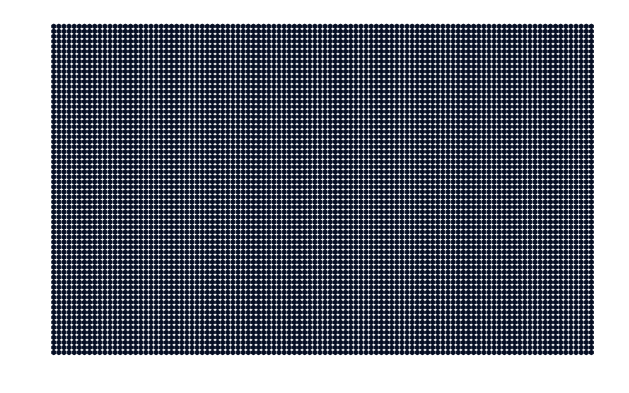

In [31]:
#viz existing map
map_colors=mapplots['TerrainType'].apply(
    lambda x:terrain2color[x]).tolist()
ax=plt.figure(figsize=(
    mapw/10,maph/10)).add_subplot(111)
plt.scatter([j for i in range(
    maph) for j in range(mapw)],
    [i for i in range(maph) for j in range(mapw)],
    s=20,marker='h',
    c=map_colors)
plt.axis('off')
plt.show()

### create map

In [32]:
#create map
if horizontal:
    mapw,maph=maph,mapw
m=Basemap(projection=projection_type,
              lon_0=lon_centre,
              lat_0=lat_centre,
              width=maph*scaler,
              height=mapw*scaler,)

#show land and sea in different colors
m.drawlsmask(land_color='k',
    ocean_color='w',)

#save image
plt.savefig('mask.png',bbox_inches='tight',
            pad_inches=-.05)
plt.clf()

<Figure size 432x288 with 0 Axes>

In [33]:
#create map
m=Basemap(projection=projection_type,
              lon_0=lon_centre,
              lat_0=lat_centre,
              width=maph*scaler,
              height=mapw*scaler,)

#blue marble is my fav
#it is similar to google earth
#m.shadedrelief()
#the problem with shaded relief is
#it is harder to distinguish different terrains for computers
m.bluemarble()

#you can draw country border to assist you in true start location
#m.drawcountries()

plt.savefig('plot.png',bbox_inches='tight',
            pad_inches=-.05)
plt.clf()

<Figure size 432x288 with 0 Axes>

In [34]:
#create hill map
m=Basemap(projection=projection_type,
              lon_0=lon_centre,
              lat_0=lat_centre,
              width=maph*scaler,
              height=mapw*scaler,)

#brown represents mountains instead of desert in etopo
m.etopo()

plt.savefig('hills.png',bbox_inches='tight',
            pad_inches=-.05)
plt.clf()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

In [35]:
#create river map
m=Basemap(projection=projection_type,
              lon_0=lon_centre,
              lat_0=lat_centre,
              width=maph*scaler,
              height=mapw*scaler,)

m.drawrivers(color='k',linewidth=2,antialiased=True)

plt.savefig('rivers.png',bbox_inches='tight',
            pad_inches=-.05)
plt.clf()

<Figure size 432x288 with 0 Axes>

In [36]:
#scale down into civmap
img=cv2.imread('plot.png')
new_img=cv2.resize(img,dsize=(maph,mapw,),
           interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('plot.png',new_img)

#scale down into civmap
img=cv2.imread('mask.png')
new_img=cv2.resize(img,dsize=(maph,mapw,),
           interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('mask.png',new_img)

#scale down into civmap
img=cv2.imread('hills.png')
new_img=cv2.resize(img,dsize=(maph,mapw,),
           interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('hills.png',new_img)

#scale down into civmap
img=cv2.imread('rivers.png',0)
new_img=cv2.resize(img,dsize=(maph,mapw,),
           interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('rivers.png',new_img)

True

### terrains

In [37]:
#read image into numpy array
img=cv2.imread('mask.png',1)

#draw the border between land and sea
#rotate 90 to fit civmap
lsmask=cluster_predict(cv2.rotate(img,
            cv2.cv2.ROTATE_90_CLOCKWISE),masque)

#read image into numpy array
img=cv2.imread('plot.png',1)

#get simplified colors
#rotate 90 to fit civmap
assignment=cluster_predict(cv2.rotate(img,
            cv2.cv2.ROTATE_90_CLOCKWISE),color2terrain)

#read image into numpy array
img=cv2.imread('hills.png',1)

#get mountain regions
#rotate 90 to fit civmap
hills=cluster_predict(cv2.rotate(img,
            cv2.cv2.ROTATE_90_CLOCKWISE),topo_color)

#read image into numpy array
img=cv2.imread('rivers.png',1)

#erode to get river shape
#img=cv2.erode(img,np.ones((2,2),'uint8'),iterations=1)

#rotate 90 to fit civmap
rivers=cluster_predict(cv2.rotate(img,
            cv2.cv2.ROTATE_90_CLOCKWISE),masque)

In [38]:
#sanity check on land/sea
result=check_land_sea(assignment,lsmask,color2terrain)

In [39]:
#map color to terrain
mapplots['TerrainType']=[list(color2terrain.values())[i] for i in result]

#search ocean tiles
ocean_tiles=mapplots[mapplots['TerrainType']=='TERRAIN_OCEAN'].index.tolist()

#find coast and ocean id
coast_id=list(color2terrain.values()).index('TERRAIN_COAST')
ocean_id=list(color2terrain.values()).index('TERRAIN_OCEAN')

#iterate through all ocean tiles
for i in ocean_tiles:

    #compute neighbor ids
    if not horizontal:
        neighbor_ids=list(neighbor_graph[i].keys())
    else:        
        neighbor_ids=list(h_neighbor_graph[i].keys())

    #neighbors of ocean tiles must be ocean/coast tiles
    #otherwise switch to coast tiles
    if set(result[neighbor_ids]).issubset(set([coast_id,ocean_id])):
        pass
    else:
        result[i]=coast_id

In [40]:
#update ocean tile
mapplots['TerrainType']=[list(color2terrain.values())[i] for i in result]

In [41]:
#get non water region
non_water_tiles=mapplots[mapplots['TerrainType'].isin(
    ['TERRAIN_PLAINS','TERRAIN_GRASS',
    'TERRAIN_DESERT','TERRAIN_TUNDRA',
    'TERRAIN_SNOW'])].index.tolist()

#get mountain region postfix for non water tiles
postfix=[list(topo_color.values())[
    i] for i in hills[non_water_tiles]]

#update mountain region
mapplots['TerrainType'].loc[
    non_water_tiles]=mapplots['TerrainType'].loc[
    non_water_tiles]+postfix

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


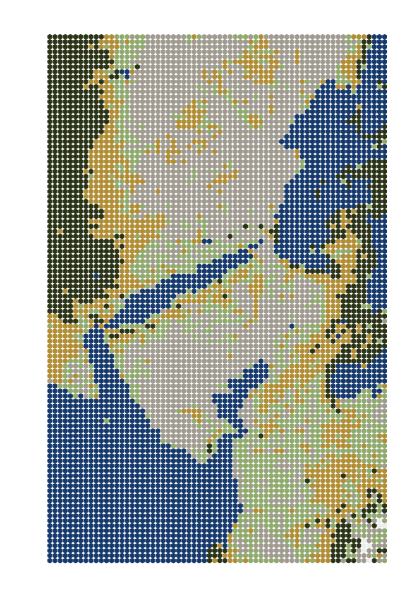

In [42]:
#viz new map
map_colors=mapplots['TerrainType'].apply(lambda x:terrain2color[x]).tolist()
ax=plt.figure(figsize=(mapw/10,maph/10)).add_subplot(111)
plt.scatter([j for i in range(maph) for j in range(mapw)],
    [i for i in range(maph) for j in range(mapw)],
    s=20,marker='h',
    c=map_colors)
plt.axis('off')
plt.show()

In [43]:
#initialize continent and impassable
mapplots['ContinentType']=''
mapplots['IsImpassable']=0

### continents

In [44]:
#get latitude longitude boundary
bndlon=m.boundarylons.copy()
bndlat=m.boundarylats.copy()

#basemap longitude is weird 
#it does not follow [-180,180]
bndlon[bndlon<-180]=bndlon[bndlon<-180]+360
bndlon[bndlon>180]=bndlon[bndlon>180]-360

#filter available continents
continent_available=get_available_continent(
                        bndlon,bndlat,
                        lon_centre,lat_centre,
                        continent_area)

#iterate through all available continents
dict_cont={}
for val in continent_available:
    lats=continent_area[val]['lat']
    lons=continent_area[val]['lon']

    basemapfile=Basemap(projection=projection_type,
                  lon_0=lon_centre,
                  lat_0=lat_centre,
                  width=maph*scaler,
                  height=mapw*scaler,)

    #draw lsmask
    basemapfile.drawlsmask(land_color='w',
                           ocean_color='w',)
    
    #plot polygon shape continent
    plot_continent(basemapfile,lats,lons)

    #save image
    plt.savefig('continent.png',bbox_inches='tight',
                    pad_inches=-.05)
    plt.clf()
        
    #down scale image
    img=cv2.imread('continent.png')
    img=cv2.resize(img,dsize=(maph,mapw,),
                   interpolation=cv2.INTER_LANCZOS4)

    #get target id
    target_id=get_target_id(img,masque,group=True)
    dict_cont[val]=target_id

<Figure size 432x288 with 0 Axes>

In [45]:
#geotagging continents
for i in dict_cont:
    if dict_cont[i].shape[0]>0:
        mapplots['ContinentType'].loc[dict_cont[i]]=i

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
#ocean does not belong to any continent
mapplots['ContinentType'][mapplots[
    'TerrainType'].isin(
    ['TERRAIN_COAST','TERRAIN_OCEAN'])]=''

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [47]:
#solve the color ambiguity between tundra and desert
for i in tundra_desert_dif:
    target_ids=mapplots[mapplots['ContinentType']==i].index
    if len(target_ids)>0:
        mapplots['TerrainType'].loc[target_ids]=mapplots[
            'TerrainType'].loc[target_ids].str.replace(
            tundra_desert_dif[i][0],tundra_desert_dif[i][1])

### natural wonders

In [48]:
#filter targets based upon coordinates
nature_available=filter_coordinates(m,nature)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [49]:
#iterate through natural wonders
nature_dict=itr_targets(lon_centre,lat_centre,
            maph,mapw,scaler,
            nature_available,masque,
                projection_type=projection_type)

<Figure size 432x288 with 0 Axes>

In [53]:
#create dataframe
plotfeatures=pd.DataFrame(columns=['ID','FeatureType'])
plotfeatures['ID']=nature_dict.keys()
plotfeatures['FeatureType']=nature_dict.values()

In [54]:
#default placements
natural_wonder_placements={'FEATURE_BARRIER_REEF': 
 {'extra':['SW','SE'],'coast':[]},
 'FEATURE_BERMUDA_TRIANGLE': 
 {'extra':['SW','SE','W'],'coast':[]},
 'FEATURE_CHOCOLATEHILLS': 
 {'extra':['SW','W','SE'],
  'coast':[]},
 'FEATURE_CLIFFS_DOVER': 
 {'extra':['SW'],'coast':[
     'W','SE',
'NW','NE']},
 'FEATURE_DEAD_SEA': 
 {'extra':['SW','SE'],'coast':[]},
 'FEATURE_EVEREST': 
 {'extra':['W','SW','SE'],
  'coast':[]},
 'FEATURE_EYE_OF_THE_SAHARA': 
 {'extra':['SW','SE','W'],'coast':[]},
 'FEATURE_EYJAFJALLAJOKULL': 
 {'extra':['W'],'coast':[]},
 'FEATURE_GALAPAGOS': 
 {'extra':['SW','SE'],'coast':[]},
 'FEATURE_GIANTS_CAUSEWAY': 
 {'extra':[],'coast':['SW','SE']},
 'FEATURE_GOBUSTAN': 
 {'extra':['SW','SE','W'],'coast':[]},
 'FEATURE_HA_LONG_BAY': 
 {'extra':['SW','SE'],'coast':[]},
 'FEATURE_LAKE_RETBA': 
 {'extra':['SW','SE'],'coast':[]},
 'FEATURE_LYSEFJORDEN': 
 {'extra':['SW','SE','W'],'coast':
  ['NE','NW']},
 'FEATURE_PAITITI': 
 {'extra':['SW','SE','W'],'coast':[]},
 'FEATURE_PAMUKKALE': 
 {'extra':['SW','SE'],'coast':[]},
 'FEATURE_PANTANAL': 
 {'extra':['SW','W','SE'],
  'coast':[]},
 'FEATURE_PIOPIOTAHI': 
 {'extra':['W','SW','SE'],
  'coast':['NW','NE']}, 
 'FEATURE_RORAIMA': 
 {'extra':['NW','NE'],
  'coast':[]},
 'FEATURE_TORRES_DEL_PAINE':  
 {'extra':['W'],'coast':[]},
 'FEATURE_UBSUNUR_HOLLOW': 
 {'extra':['NW','NE','E'],
  'coast':[]},
 'FEATURE_WHITEDESERT': 
 {'extra':['NW','NE','E'],
  'coast':[]},
 'FEATURE_YOSEMITE': 
 {'extra':['W'],'coast':[]},
 'FEATURE_ZHANGYE_DANXIA': 
 {'extra':['SW','SE'],
  'coast':[]},}

In [55]:
#prepare to check for terrains
terrain_check=plotfeatures.merge(nature,left_on='FeatureType',
                  right_on='code',how='left')

#make terrain compatible with natural wonder
no_feature_resource_id=[]
for i in terrain_check.index:
    identity=terrain_check['ID'].loc[i]
    terrain_type=terrain_check['terrain'].loc[i]
    wonder_name=terrain_check['FeatureType'].loc[i]
    mapplots.at[identity,'TerrainType']=terrain_type
        
    #convert neighbor tiles to designated terrains
    if terrain_check['taille'].loc[i]>1:
        if horizontal:
            NG=h_neighbor_graph
        else:
            NG=neighbor_graph
        arr=list(NG[identity].values())
        neighbor_ids=[]
        water_ids=[]
        for direction in natural_wonder_placements[wonder_name][
            'extra']:            
            neighbor_ids.append(
                list(NG[identity].keys())[
                    arr.index(direction)])
        for direction in natural_wonder_placements[wonder_name][
            'coast']:            
            water_ids.append(
                list(NG[identity].keys())[
                    arr.index(direction)])
        mapplots['TerrainType'].loc[
            neighbor_ids]=terrain_type
        
        #keep track of natural wonder placement
        no_feature_resource_id+=neighbor_ids
        
        #some natural wonders have to be near coast
        if len(water_ids)>0:
            mapplots['TerrainType'].loc[water_ids]='TERRAIN_COAST'
            no_feature_resource_id+=water_ids
    
    #check if passable
    if terrain_check['impassable'].loc[i]==1:
        mapplots.at[identity,'IsImpassable']=1
        if terrain_check['taille'].loc[i]>1:
            mapplots['IsImpassable'].loc[
                neighbor_ids]=1

#mountain areas impassable
mapplots['IsImpassable'][mapplots['TerrainType'].isin(impassable_terrains)]=1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
#randomly select a suitable terrain
idx=mapplots[mapplots['TerrainType'].isin(
    [
 'TERRAIN_GRASS',
 'TERRAIN_GRASS_HILLS',
 'TERRAIN_PLAINS',
 'TERRAIN_PLAINS_HILLS',])].index
lucky_id=np.random.choice(
    [i for i in idx if i not in nature_dict and i not in no_feature_resource_id],1)

#assign youth fountain to a random place
extra=pd.DataFrame(columns=plotfeatures.columns)
extra['ID']=lucky_id
extra['FeatureType']='FEATURE_FOUNTAIN_OF_YOUTH'
plotfeatures=plotfeatures.append(extra)

#add missing nature to manual checklist
nature_checklist=set(nature_available['code']).difference(set(plotfeatures['FeatureType']))

### features

In [57]:
#iterate through different features
for feature_name in set(feature['feature']):

    #filter subset
    subset=feature[feature['feature']==feature_name].copy()

    #get arbitrary amount
    num_of_features=feature_mapping[feature_name]['prob']*(maph*mapw)
    target_ids=itr_multi(
            subset,
              lon_centre,lat_centre,
              maph,mapw,scaler,masque,
              int(num_of_features))
    
    #avoid natural wonder placement
    target_ids=np.array([i for i in target_ids if i not in no_feature_resource_id])

    #check terrains
    feature_check=mapplots.loc[target_ids].copy()
    suitable_terrains=feature_mapping[feature_name]['terrains']
    feature_check['filter']=feature_check['TerrainType'].apply(
        lambda x:1 if x in suitable_terrains else 0)

    #create dataframe
    subset=pd.DataFrame(columns=plotfeatures.columns)
    if feature_name!='FEATURE_MARSH':
        subset['ID']=feature_check['ID'][feature_check['filter']==1].tolist()
        subset['FeatureType']=feature_name
    else:
        
        #assign marsh and floodplains accordingly
        feature_check=feature_check[feature_check['filter']==1].copy()
        feature_check.reset_index(inplace=True,drop=True)
        feature_check['name']='FEATURE_MARSH'
        feature_check['name'][feature_check['TerrainType']=='TERRAIN_PLAINS']='FEATURE_FLOODPLAINS_PLAINS'
        feature_check['name'][feature_check['TerrainType']=='TERRAIN_DESERT']='FEATURE_FLOODPLAINS'
        feature_check['name'][feature_check['TerrainType']=='TERRAIN_GRASS']='FEATURE_FLOODPLAINS_GRASSLAND'
        ind=feature_check[feature_check['TerrainType']=='TERRAIN_GRASS'].index
        target_ids=np.random.choice(ind,size=len(ind)//2, replace=False)
        feature_check['name'].loc[target_ids]='FEATURE_MARSH'
        subset['ID']=feature_check['ID'].tolist()
        subset['FeatureType']=feature_check['name'].tolist()
        
    plotfeatures=plotfeatures.append(subset)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

<Figure size 432x288 with 0 Axes>

In [58]:
#drop duplicate id and reset index
plotfeatures.reset_index(inplace=True,drop=True)
plotfeatures=plotfeatures.loc[plotfeatures['ID'].drop_duplicates().index]

In [59]:
#get volcano ids
volcano_ids=plotfeatures['ID'][
    plotfeatures['FeatureType'].isin([
    'FEATURE_KILIMANJARO',
'FEATURE_EYJAFJALLAJOKULL',
'FEATURE_VESUVIUS',
'FEATURE_VOLCANO'])].tolist()

#get volcano neighbor ids
volcano_neighbor_ids=[]
for i in volcano_ids:
    
    #compute neighbor ids
    if not horizontal:
        neighbor_ids=list(neighbor_graph[i].keys())
    else:        
        neighbor_ids=list(h_neighbor_graph[i].keys())
    volcano_neighbor_ids+=neighbor_ids

In [60]:
#some features can be randomly generated
for feature_name in feature_mapping:
    if feature_mapping[feature_name]['prob']==1:
        continue
        
    #certain features only exist in volcanic area
    if feature_name in ['FEATURE_GEOTHERMAL_FISSURE',
                          'FEATURE_VOLCANIC_SOIL']:
        subset=mapplots.loc[volcano_neighbor_ids].copy()
    elif feature_name in set(plotfeatures['FeatureType']):
        continue
    else:
        subset=mapplots.copy()
    
    #avoid natural wonder placement
    subset=subset[~subset['ID'].isin(no_feature_resource_id)]
    
    #randomly assignment
    plotfeatures=random_features(plotfeatures,subset,
            feature_name,
            feature_mapping[feature_name]['prob'],
            feature_mapping[feature_name]['terrains'],
                    )

In [61]:
#remove multi feature on the same tile
plotfeatures.reset_index(inplace=True,drop=True)
plotfeatures=plotfeatures.loc[plotfeatures['ID'].drop_duplicates().index]

### true start locations

In [62]:
#filter targets based upon coordinates
tsl_available=filter_coordinates(m,tsl)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [63]:
#iterate through true start locations
tsl_dict=itr_targets(lon_centre,lat_centre,
            maph,mapw,scaler,
            tsl_available,masque,
            name_col='code',
            projection_type=projection_type)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\li

<Figure size 432x288 with 0 Axes>

In [64]:
#create start position dataframe
startpos=pd.DataFrame(columns=['Plot',
                               'Type',
                               'Value'])
startpos['Plot']=tsl_dict.keys()
startpos['Type']='LEADER'
startpos['Value']=[i for i in tsl_dict.values()]

In [65]:
#check players spawn in impassable terrains
player_check=mapplots.merge(startpos,right_on=['Plot'],
               left_on=['ID'],
              how='right')
player_check1=player_check[
    player_check['ID'].isin(no_feature_resource_id)]
player_check2=player_check[
    player_check['TerrainType'].isin(
        impassable_terrains+['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])]
player_check=player_check1.append(player_check2)
player_check=player_check.drop_duplicates()

#exclude maori which starts off at ocean tile
player_check=player_check[player_check['Value']!='LEADER_KUPE']

In [66]:
#assign leaders to available neighbor tiles
player_checklist=[]
for identity in player_check['ID']:
    
    #compute neighbor ids
    if not horizontal:
        neighbor_ids=list(neighbor_graph[i].keys())
    else:        
        neighbor_ids=list(h_neighbor_graph[i].keys())
    neighbors=mapplots.loc[neighbor_ids]    
    available_neighbors=neighbors[~neighbors[
        'TerrainType'].isin(
        impassable_terrains+['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])]
    available_neighbors=available_neighbors[
        ~available_neighbors[
        'ID'].isin(no_feature_resource_id)]
    
    if not available_neighbors.empty:
        startpos['Plot'][
            startpos['Value']==tsl_dict[
                identity]]=available_neighbors.index[0]
    
    #if neighbor tiles are not available
    #delete tsl of this leader and raise error
    else:
        startpos.drop(startpos[
            startpos['Plot']==identity].index,
                      inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
#avoid same tsl for two civs
startpos=startpos.loc[startpos['Plot'].drop_duplicates().index]

#add missing tsl to manual checklist
player_checklist=list(set(tsl_available['code']).difference(set(startpos['Value'])))

In [68]:
#recreate players table
players=pd.DataFrame(human_player)

#count number of city states
spfilter=startpos['Value'].apply(lambda x:1 if 'LEADER_MINOR_CIV_' in x else 0)

#repeat civs
sub1=pd.DataFrame(ai_civs)
sub1=sub1.loc[sub1.index.repeat(len(spfilter)-len(spfilter[spfilter==1])-1)]

#repeat city states
sub2=pd.DataFrame(ai_cities)
sub2=sub2.loc[sub2.index.repeat(len(spfilter[spfilter==1]))]

#create players
players=players.append(sub1).append(sub2)
players.reset_index(inplace=True,drop=True)
players['ID']=players.index

### resources

In [69]:
#required features and terrains for resources
resource['features']=resource['resource'].apply(
    lambda x:resource_mapping[x]['features'])
resource['terrains']=resource['resource'].apply(
    lambda x:resource_mapping[x]['terrains'])

In [70]:
#create empty dataframe
plotresources=pd.DataFrame(columns=['ID',
                                    'ResourceType',
                                    'ResourceCount'])

In [71]:
#check terrain with natural wonders
resource_check=mapplots.merge(plotfeatures,on='ID',
              how='left')

In [72]:
#iterate through different resources
for resource_name in resource_mapping:
    
    #check resource required terrains and features
    if pd.isna(resource_mapping[resource_name][
        'terrains']):
        available_terrains=[]
    else:
        available_terrains=resource_mapping[
            resource_name]['terrains'].split(';')
    if pd.isna(resource_mapping[resource_name][
        'features']):
        available_features=[]
    else:
        available_features=resource_mapping[
            resource_name]['features'].split(';')

    #find available ids
    s1=resource_check[
        resource_check['TerrainType'].isin(
            available_terrains)][
        resource_check['FeatureType'].isnull()][
        resource_check['IsImpassable']==0].index
    s2=resource_check[resource_check[
        'FeatureType'].isin(
        available_features)][
        resource_check['IsImpassable']==0].index
    available_ids=set(s1).union(set(s2)).difference(
        set(no_feature_resource_id))

    #compute number of resources required
    num_of_resource=int(resource_mapping[
              resource_name]['prob']*mapw*maph)

    
    if len(available_ids)<=num_of_resource:
        target_ids=list(available_ids)
    else:
        
        #find random lucky ids
        if resource_name in random_resources:
            target_ids=np.random.choice(
                list(available_ids),
                num_of_resource,
                replace=False)
        else:
            
            #get ids from coordinates
            #filter ids based upon terrains and features
            filtered_ids=itr_multi(
                resource[resource[
                    'resource']==resource_name],
                  lon_centre,lat_centre,
                  maph,mapw,scaler,masque,
                  int(resource_mapping[
                      resource_name]['prob']*maph*mapw))
            target_ids=list(set(
                filtered_ids).intersection(
                available_ids))

    #convert to dataframe
    subset=pd.DataFrame(columns=plotresources.columns)
    subset['ID']=target_ids
    subset['ResourceType']=resource_name
    subset['ResourceCount']=1
    plotresources=plotresources.append(subset)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match Da

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match Da

<Figure size 432x288 with 0 Axes>

In [73]:
#find passable terrains
passable_terrains=mapplots[~mapplots['TerrainType'].isin(
    impassable_terrains+['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])].index

#find terrains without resources
empty_space=set(passable_terrains).difference(set(plotresources['ID']))

#avoid natural wonders and their affiliated tiles
empty_space=empty_space.difference(set(no_feature_resource_id))
empty_space=empty_space.difference(set(nature_dict.keys()))

#avoid youth fountain
empty_space.remove(lucky_id[0])

#dbscan to find no resource land
clf=sklearn.cluster.DBSCAN(
    eps=(2)**0.5,
min_samples=tolerance4noresource**2)
X=np.array([[i%mapw for i in empty_space],
[i//mapw for i in empty_space]]).T
clf.fit(X)

DBSCAN(eps=1.4142135623730951, min_samples=9)

In [74]:
#set median data point of the cluster as leyline
arr=[]
for i in np.unique(clf.labels_):
    if i>=0:
        arr.append(np.median(X[
            np.where(clf.labels_==i)],axis=0))
target_ids=[round(i[1],0)*mapw+round(i[0],0) for i in arr]

#add ley line
subset=pd.DataFrame(columns=plotresources.columns)
subset['ID']=target_ids
subset['ResourceType']='RESOURCE_LEY_LINE'
subset['ResourceCount']=1
plotresources=plotresources.append(subset)

In [75]:
#remove multi resource on the same tile
plotresources.reset_index(inplace=True,drop=True)
plotresources=plotresources.loc[
    plotresources['ID'].drop_duplicates().index]

In [76]:
#if resource has not been allocated
#prepare to raise error
resource_checklist=list(set(
    resource_mapping.keys()).difference(
    set(plotresources['ResourceType'])))

In [77]:
#adjust horizontal map coordinates
if horizontal:
    mapplots=horizontal_adjustment(mapplots,maph,mapw,'ID')
    plotfeatures=horizontal_adjustment(plotfeatures,maph,mapw,'ID')
    plotresources=horizontal_adjustment(plotresources,maph,mapw,'ID')
    startpos=horizontal_adjustment(startpos,maph,mapw,'Plot')

### rivers

In [78]:
#exclude ocean tiles
if horizontal:
    s1=set([maph-1-x//mapw+(x%mapw)*maph for x in np.where(rivers==0)[0]])
else:
    s1=set(np.where(rivers==0)[0])
s2=set(mapplots[~mapplots['TerrainType'].isin(['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])].index)
target_ids=s1.intersection(s2)

#initialize
set_rivers=set(target_ids)
visited=[]
queue=[]
flowW=[-1 for _ in range(len(mapplots))]
flowNE=[-1 for _ in range(len(mapplots))]
flowNW=[-1 for _ in range(len(mapplots))]

#get starting point of rivers which is land adjacent to ocean
for i in target_ids:
    neighbor_ids=list(neighbor_graph[i].keys())
    subset=mapplots.loc[neighbor_ids].copy()
    subset=subset[subset['TerrainType']=='TERRAIN_COAST'].copy()
    if not subset.empty:        
        queue.append(i)
        
        #the most annoying part of river is waterflow
        #if the waterflow is not set up probably
        #you do not visually see the river in game
        #becuz the water doesnt flow from ocean to inland
        #the direction in game is contrary to the real life
        #though you can still get river adjacency bonus 
        #despite not visually seeing it
        #one way to see your rivers is using map editor 
        flowW,flowNW,flowNE=waterflow_design(neighbor_graph,
                    i,subset['ID'].iloc[0],
                    flowW,flowNW,flowNE)

#create river track
while queue:

    #use dfs to track each river
    #check the link below for more details on dfs
    # https://github.com/je-suis-tm/graph-theory/blob/master/BFS%20DFS%20on%20DCG.ipynb
    current_vertex=queue.pop(0)
    visited.append(current_vertex)

    #find its adjacent vertices connected to the river
    s1=set(neighbor_graph[current_vertex].keys())

    #however,each vertex can only be visited once
    s2=set(visited)
    subset=list(s1.intersection(set_rivers).difference(s2))
    
    #waterflow
    for adj in subset:
        flowW,flowNW,flowNE=waterflow_design(neighbor_graph,current_vertex,adj,
                    flowW,flowNW,flowNE)

    #remove duplicates in the queue
    for i in subset:
        if i in queue:
            queue.remove(i)
    queue=subset+queue

#construct dataframe
plotrivers=pd.DataFrame(columns=['ID', 'IsNEOfRiver',
            'IsWOfRiver', 'IsNWOfRiver', 'EFlowDirection',
       'SEFlowDirection', 'SWFlowDirection'],
                       index=mapplots.index)
plotrivers['ID']=plotrivers.index
plotrivers['EFlowDirection']=flowW
plotrivers['SEFlowDirection']=flowNW
plotrivers['SWFlowDirection']=flowNE
plotrivers['IsNEOfRiver']=np.where(plotrivers['SWFlowDirection']!=-1,1,0)
plotrivers['IsWOfRiver']=np.where(plotrivers['EFlowDirection']!=-1,1,0)
plotrivers['IsNWOfRiver']=np.where(plotrivers['SEFlowDirection']!=-1,1,0)

### cliffs

In [79]:
#size determines the number of cliffs
falaise['taille']=4

#get coastal area
target_ids=itr_multi(
            falaise,
              lon_centre,lat_centre,
              maph,mapw,scaler,masque,
              len(falaise))
if horizontal:
    target_ids=np.array(
        [maph-1-x//mapw+(x%mapw)*maph for x in target_ids])

<Figure size 432x288 with 0 Axes>

In [80]:
neighbor_ids=neighbor_graph[6281].keys()
neighbors=mapplots[mapplots['ID'].isin(neighbor_ids)][
    mapplots['TerrainType'].isin(['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])].copy()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [81]:
#get continent shelf area
continent_shelf=mapplots[mapplots['ID'].isin(target_ids)][
    ~mapplots['TerrainType'].isin(['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])]

#initialize
cliffW=[0 for _ in range(len(mapplots))]
cliffNE=[0 for _ in range(len(mapplots))]
cliffNW=[0 for _ in range(len(mapplots))]

#iterate through potential cliffs
for i in continent_shelf['ID']:
    
    #find neighbors who are water tiles
    neighbor_ids=neighbor_graph[i].keys()
    neighbors=mapplots[mapplots['ID'].isin(neighbor_ids)][
    mapplots['TerrainType'].isin(['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])].copy()
    
    #skip
    if len(neighbors)==0:
        continue
    
    #avoid isolated cliff island
    if len(neighbors)>=4:
        neighbors=neighbors.iloc[:3]
    
    #generate cliff
    for j in neighbors.index:
        if neighbor_graph[i][j]=='NW':
            cliffNW[i]=1
        if neighbor_graph[i][j]=='W':
            cliffW[i]=1
        if neighbor_graph[i][j]=='NE':
            cliffNE[i]=1
        if neighbor_graph[i][j]=='E':
            cliffW[j]=1
        if neighbor_graph[i][j]=='SE':
            cliffNW[j]=1
        if neighbor_graph[i][j]=='SW':
            cliffNE[j]=1        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [82]:
#create dataframe
plotcliffs=pd.DataFrame(columns=['ID',
                    'IsNEOfCliff', 'IsWOfCliff', 'IsNWOfCliff'],
                        index=mapplots.index)
plotcliffs['ID']=plotcliffs.index
plotcliffs['IsNEOfCliff']=cliffNE
plotcliffs['IsNWOfCliff']=cliffNW
plotcliffs['IsWOfCliff']=cliffW

### update civmap database

In [83]:
text=''

if len(nature_checklist)>0:
    text+=f"""\nmanually assign natural wonders of 
        {', '.join(nature_checklist)}\n"""
    
if len(player_checklist)>0:
    text+=f"""\nmanually assign TSL of 
        {', '.join(player_checklist)}\n"""
    
if len(resource_checklist)>0:
    text+=f"""manually assign location of 
        {', '.join(resource_checklist)}\n"""
    
if len(player_checklist)>0 or \
len(resource_checklist)>0:
    assert False,text

AssertionError: 
manually assign TSL of 
        LEADER_BASIL, LEADER_MENELIK, LEADER_TRAJAN, LEADER_CYRUS, LEADER_MINOR_CIV_VALLETTA, LEADER_GANDHI, LEADER_DIDO, LEADER_MINOR_CIV_TARUGA, LEADER_MINOR_CIV_SAMARKAND, LEADER_MINOR_CIV_BABYLON, LEADER_MINOR_CIV_VATICAN_CITY, LEADER_MINOR_CIV_KABUL, LEADER_MINOR_CIV_PRESLAV
manually assign location of 
        RESOURCE_SPICES, RESOURCE_TRUFFLES, RESOURCE_COCOA, RESOURCE_COFFEE, RESOURCE_AMBER, RESOURCE_JADE, RESOURCE_DYES, RESOURCE_INCENSE


In [84]:
#new name
modtext.drop_duplicates().to_sql('ModText',
               con=con,if_exists='replace',
               index=False)

In [85]:
#upsert map into database
mapplots['IsImpassable']=mapplots['IsImpassable'].astype(int)
mapplots.drop_duplicates().to_sql('Plots',
                con=con,if_exists='replace',
                index=False)

In [86]:
#remove all features
con.execute("DELETE FROM PlotFeatures;");
con.commit()

#upsert into database
plotfeatures.drop_duplicates().to_sql('PlotFeatures',
                    con=con,if_exists='replace',
                    index=False)

In [87]:
#remove all resources
con.execute("DELETE FROM PlotResources;");
con.commit()

#data type integrity to prevent error
plotresources['ID']=plotresources['ID'].astype(int)

#upsert into database
plotresources.drop_duplicates().to_sql('PlotResources',
                     con=con,if_exists='replace',
                     index=False)

In [88]:
#update tsl
con.execute("DELETE FROM StartPositions;");
con.commit()
con.execute("DELETE FROM PlayerAttributes;");
con.commit()
con.execute("DELETE FROM Players;");
con.commit()

startpos.drop_duplicates().to_sql('StartPositions',
                con=con,if_exists='replace',
                index=False)
players.drop_duplicates().to_sql('Players',con=con,
               if_exists='replace',index=False)

In [89]:
#remove all rivers
con.execute("DELETE FROM PlotRivers;");
con.commit()

#data type integrity to prevent error
for i in plotrivers.columns:
    plotrivers[i]=plotrivers[i].astype(int)

#upsert into database
plotrivers.drop_duplicates().to_sql('PlotRivers',
                     con=con,if_exists='replace',
                     index=False)

In [90]:
#remove all Cliffs
con.execute("DELETE FROM PlotCliffs;");
con.commit()

#data type integrity to prevent error
for i in plotcliffs.columns:
    plotcliffs[i]=plotcliffs[i].astype(int)

#upsert into database
plotcliffs.drop_duplicates().to_sql('PlotCliffs',
                     con=con,if_exists='replace',
                     index=False)

In [91]:
#revert back to civ6map
con.close()
os.rename('civ.db','mideast.Civ6Map')

### test

In [ ]:
# # k means to get centroid colors
# # useful when you prefer other types of viz to show topographic map

# from sklearn.cluster import KMeans
# img=cv2.imread('indir.png')

# num_of_clusters=7
# X=img.reshape(img.shape[0]*img.shape[1],3)[:,[2,1,0]]
# clf=KMeans(n_clusters=num_of_clusters)
# clf.fit(X)
# centroids=[i for i in range(clf.cluster_centers_.shape[0])]
# for i in range(clf.cluster_centers_.shape[0]):
#     centroids[i]=rgb_to_hex(tuple([int(np.ceil(j)) for j in clf.cluster_centers_[i].tolist()]))
# print(centroids)
# plt.scatter(range(num_of_clusters),range(num_of_clusters),c=centroids,s=500)
# plt.show()

In [ ]:
# #viz new map
# map_colors=mapplots['TerrainType'].apply(lambda x:terrain2color[x]).tolist()
# if horizontal:
#     plt.scatter([j for i in range(mapw) for j in range(maph)],
#         [i for i in range(mapw) for j in range(maph)],
#         s=20,marker='h',alpha=0.5,
#         c=map_colors)
# else:
#     plt.scatter([j for i in range(maph) for j in range(mapw)],
#         [i for i in range(maph) for j in range(mapw)],
#         s=20,marker='h',alpha=0.5,
#         c=map_colors)


# for i in startpos['Plot']:
#     if horizontal:
#         plt.scatter(i%maph,i//maph,
#                     label=startpos['Value'][startpos['Plot']==i].item())
#     else:
#         plt.scatter(i%mapw,i//mapw,
#                     label=startpos['Value'][startpos['Plot']==i].item())
# plt.legend(loc=8,bbox_to_anchor=(0,-1),
#           ncol=2)
# plt.axis('off')
# plt.show()

In [ ]:
# arr=plotresources['ResourceType'].tolist()

# for i in set(arr):
#     print(i,arr.count(i))

In [ ]:
# startpos.merge(mapplots,
#               left_on=['Plot'],
#               right_on=['ID'],how='left')

In [ ]:
# arr=plotfeatures['FeatureType'].tolist()

# for i in set(arr):
#     print(i,arr.count(i))